In [49]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

label_file = "hirise-v3-cv-dataset/hirise-text-labels-3class.txt"
image_dir = "hirise-v3-cv-dataset/map-proj-v3"

In [50]:
train_data = pd.read_csv(label_file, delimiter="\s+")
Y = train_data[['label']]
print(Y)

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

             label
0     slope_streak
1     slope_streak
2     slope_streak
3     slope_streak
4     slope_streak
...            ...
5224  swiss_cheese
5225  swiss_cheese
5226  swiss_cheese
5227  swiss_cheese
5228  swiss_cheese

[5229 rows x 1 columns]


In [51]:
idg = ImageDataGenerator(rescale=1./255)
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [52]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
def create_new_model():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model

# The cell below trains the data and takes 1 hour 15 min. Don't run if you already have saved models!

In [55]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'saved_models_3class/'
fold_var = 1
n=5229
num_epochs = 10
img_width = 227
img_height = 227

for train_index, val_index in kf.split(np.zeros(n),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
	
	# CREATE NEW MODEL
	model = create_new_model()
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='adam',
		      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	history = model.fit(train_data_generator,
			    epochs=num_epochs,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY
	#		:
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(save_dir + "/model_" + str(fold_var) + ".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.4535
Epoch 1: val_accuracy improved from -inf to 0.36138, saving model to saved_models_3class/model_1.h5


/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 7s 41ms/step - loss: 1.1095 - accuracy: 0.4535 - val_loss: 1.0572 - val_accuracy: 0.3614
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.4623
Epoch 2: val_accuracy did not improve from 0.36138
131/131 [==============================] - 4s 33ms/step - loss: 1.0632 - accuracy: 0.4623 - val_loss: 1.0794 - val_accuracy: 0.3614
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.4669
Epoch 3: val_accuracy did not improve from 0.36138
131/131 [==============================] - 4s 34ms/step - loss: 1.0577 - accuracy: 0.4669 - val_loss: 1.0913 - val_accuracy: 0.3614
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.4669
Epoch 4: val_accuracy did not improve from 0.36138
131/131 [==============================] - 4s 34ms/step - loss: 1.0589 - accuracy: 0.4669 - val_loss: 1.0996 - val_accuracy: 0.3614
Epoch 5/10
131/131 [===========

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 7s 39ms/step - loss: 1.1179 - accuracy: 0.4712 - val_loss: 1.1035 - val_accuracy: 0.3337
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.4738
Epoch 2: val_accuracy did not improve from 0.33365
131/131 [==============================] - 5s 34ms/step - loss: 1.0547 - accuracy: 0.4738 - val_loss: 1.1221 - val_accuracy: 0.3337
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.4738
Epoch 3: val_accuracy did not improve from 0.33365
131/131 [==============================] - 4s 34ms/step - loss: 1.0570 - accuracy: 0.4738 - val_loss: 1.0991 - val_accuracy: 0.3337
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.4738
Epoch 4: val_accuracy did not improve from 0.33365
131/131 [==============================] - 4s 34ms/step - loss: 1.0524 - accuracy: 0.4738 - val_loss: 1.1151 - val_accuracy: 0.3337
Epoch 5/10
131/131 [===========

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 7s 40ms/step - loss: 1.0653 - accuracy: 0.4831 - val_loss: 1.1007 - val_accuracy: 0.2887
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.4853
Epoch 2: val_accuracy did not improve from 0.28872
131/131 [==============================] - 5s 34ms/step - loss: 1.0476 - accuracy: 0.4853 - val_loss: 1.1303 - val_accuracy: 0.2887
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.4846
Epoch 3: val_accuracy did not improve from 0.28872
131/131 [==============================] - 4s 34ms/step - loss: 1.0529 - accuracy: 0.4846 - val_loss: 1.1247 - val_accuracy: 0.2887
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.0458 - accuracy: 0.4851
Epoch 4: val_accuracy did not improve from 0.28872
131/131 [==============================] - 5s 34ms/step - loss: 1.0458 - accuracy: 0.4851 - val_loss: 1.1460 - val_accuracy: 0.2887
Epoch 5/10
131/131 [===========

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 7s 41ms/step - loss: 1.0900 - accuracy: 0.3854 - val_loss: 1.0518 - val_accuracy: 0.7008
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 1.0761 - accuracy: 0.3873
Epoch 2: val_accuracy did not improve from 0.70076
131/131 [==============================] - 5s 35ms/step - loss: 1.0761 - accuracy: 0.3873 - val_loss: 1.0546 - val_accuracy: 0.1185
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.0742 - accuracy: 0.3909
Epoch 3: val_accuracy did not improve from 0.70076
131/131 [==============================] - 5s 34ms/step - loss: 1.0742 - accuracy: 0.3909 - val_loss: 1.0166 - val_accuracy: 0.7008
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.0763 - accuracy: 0.3930
Epoch 4: val_accuracy did not improve from 0.70076
131/131 [==============================] - 5s 34ms/step - loss: 1.0763 - accuracy: 0.3930 - val_loss: 1.0305 - val_accuracy: 0.7008
Epoch 5/10
131/131 [===========

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 8s 42ms/step - loss: 1.1010 - accuracy: 0.4137 - val_loss: 1.0393 - val_accuracy: 0.5445
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 1.0646 - accuracy: 0.4197
Epoch 2: val_accuracy did not improve from 0.54450
131/131 [==============================] - 5s 35ms/step - loss: 1.0646 - accuracy: 0.4197 - val_loss: 1.0567 - val_accuracy: 0.5445
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.4187
Epoch 3: val_accuracy did not improve from 0.54450
131/131 [==============================] - 5s 34ms/step - loss: 1.0643 - accuracy: 0.4187 - val_loss: 1.0828 - val_accuracy: 0.5445
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.0651 - accuracy: 0.4152
Epoch 4: val_accuracy did not improve from 0.54450
131/131 [==============================] - 5s 34ms/step - loss: 1.0651 - accuracy: 0.4152 - val_loss: 1.0620 - val_accuracy: 0.5445
Epoch 5/10
131/131 [===========

# Evaluate saved model performance

In [56]:
def load_trained_model(model_file):
    model = create_new_model()
    return model.load_weights(model_file)

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 19ms/step


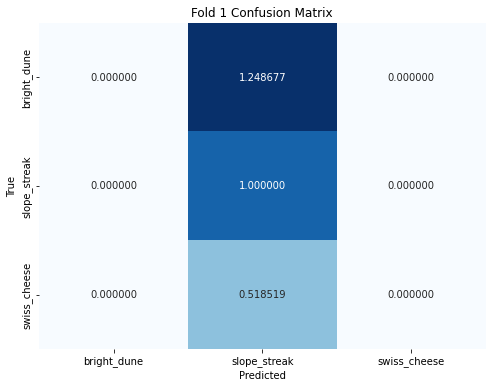

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 19ms/step


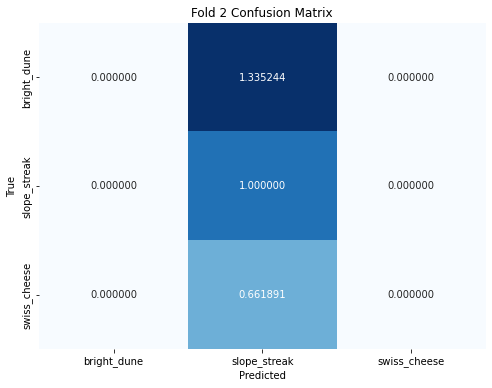

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 19ms/step


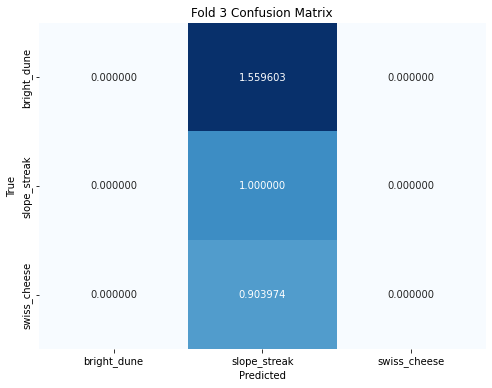

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 19ms/step


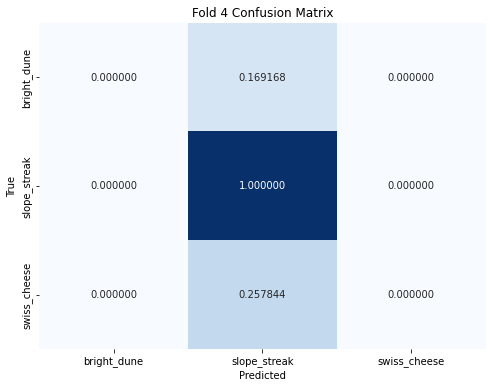

Found 4184 validated image filenames belonging to 3 classes.
Found 1045 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 20ms/step


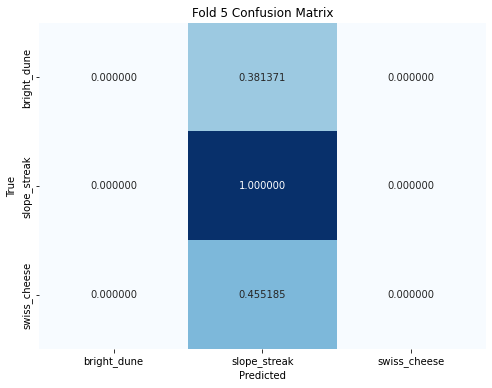

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fold_var = 1
n=5229
num_epochs = 10
img_width = 227
img_height = 227

for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
	
    train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
    
    class_labels = list(valid_data_generator.class_indices.keys())
    
    load_trained_model(save_dir + "/model_" + str(fold_var) + ".h5")
    
    # perform validation predictions
    val_predictions = model.predict(valid_data_generator)
    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(val_predictions, axis=1)
    
    # generate confusion matrix
    confusion = confusion_matrix(valid_data_generator.classes, predicted_labels)
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion / confusion.astype(float).sum(axis=1), annot=True, fmt="f", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Fold ' + str(fold_var) +  ' Confusion Matrix')
    plt.show()
    
    fold_var += 1